## Programming Assignment 5
#### In this assignment, you will be implementing Tomasi-Kanade	Factorization algorithm	for Rigid Structure from Motion.

### Task 1
#### Load the data file and generate a 2D image dataset	by generating an orthographic camera with optical axis paralle to the XY plane, which rotates around the teapot	in 10° increments and always looks towards the center of the object
#### Note: Code for loading the point cloud and visualizing it has been given to you. Further build on it and take images of the teapot and visualize them

In [0]:
import numpy as np
import math

In [0]:
from scipy.io import loadmat
x = loadmat('teapot.mat')

In [0]:
a = []
b = []
c = []
for points in x['verts']:
    a.append(points[0])
    b.append(points[1])
    c.append(points[2])

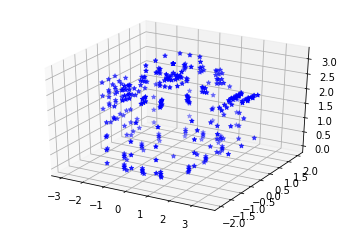

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a,b,c, c='b', marker='*')

In [0]:
### Your implementation comes here
intrinsic = np.array([[1, 0, 0],[0, 1, 0]])

def rotation_matrix_y(angle):
    rot_angle=math.radians(angle)
    R = np.array([[math.cos(rot_angle),0,math.sin(rot_angle)],[0,1,0],[-math.sin(rot_angle),0,math.cos(rot_angle)]])
    return R      

In [0]:
### Your implementation comes here
# Hint: new2Dpts = K[R|T]*3DPoints
IterationList = np.arange(0, 360, 10).tolist()
K = []

for index in IterationList:
  RotationMatrix = rotation_matrix_y(index)
  value = np.matmul(intrinsic, RotationMatrix)
  K.append(value)

K = np.array(K)
K = np.vstack(K)

Verticies = np.array(x["verts"])
VerticiesTranspose = Verticies.T

new2Dpts = np.matmul(K, VerticiesTranspose)

In [7]:
#shape
new2Dpts.shape

(72, 306)

In [8]:
#values 
new2Dpts

array([[ 1.4       ,  1.4       ,  0.784     , ...,  1.5       ,
         0.798     ,  1.425     ],
       [ 0.        , -0.784     , -1.4       , ..., -0.84      ,
        -1.425     , -0.798     ],
       [ 1.79548648,  1.79548648,  1.1888449 , ...,  1.49023524,
         0.78587659,  1.40335105],
       ...,
       [ 0.        , -0.784     , -1.4       , ..., -0.84      ,
        -1.425     , -0.798     ],
       [ 0.96197523,  0.96197523,  0.35533365, ...,  1.46418802,
         0.78587659,  1.40335105],
       [ 0.        , -0.784     , -1.4       , ..., -0.84      ,
        -1.425     , -0.798     ]])

### Task 2
#### Use the data generated in previous task to generate a W matrix, and use that as input in Tomasi Kanade Factorization method to compute the 3D structure

In [0]:
### Your implementation for Tomasi Kanade Factorization method comes here
u, s, vh = np.linalg.svd(new2Dpts)

vhUpdated = vh[0:3, 0:]
sUpdated = s[0:3, ]
uUpdated = u[0:, 0:3]

newS = np.identity(3)
for x in range(3):
  newS[x][x] = s[x]

s = newS


In [0]:
MatrixA = []
MatrixB = []

Length = len(uUpdated)
IterationList = np.arange(0, Length, 2).tolist()
for index in IterationList:
  MatrixB.append(1)
  MatrixB.append(0)
  MatrixB.append(1)

  Rows = uUpdated[index: index + 2]

  index1 = Rows[0][0]*Rows[0][0]
  index2 = 2*Rows[0][0]*Rows[0][1]
  index3 = 2*Rows[0][0]*Rows[0][2]
  index4 = Rows[0][1]*Rows[1][0]
  index5 = 2*Rows[0][1]*Rows[0][2]
  index6 = Rows[0][2]*Rows[0][2]

  Row1 = [index1, index2, index3, index4, index5, index6]
  MatrixA.append(Row1)

  index1 = Rows[0][0]*Rows[1][0]
  index2 = Rows[0][1]*Rows[1][0] + Rows[0][2]*Rows[1][1]
  index3 = Rows[0][2]*Rows[1][0] + Rows[0][0]*Rows[1][2]
  index4 = Rows[0][1]*Rows[1][1]
  index5 = Rows[0][2]*Rows[1][1] + Rows[0][1]*Rows[1][2]
  index6 = Rows[0][2]*Rows[1][2]

  Row2 = [index1, index2, index3, index4, index5, index6]
  MatrixA.append(Row2)

  index1 = Rows[1][0]*Rows[1][0]
  index2 = 2*Rows[1][0]*Rows[1][1]
  index3 = 2*Rows[1][0]*Rows[1][2]
  index4 = Rows[1][1]*Rows[1][1]
  index5 = 2*Rows[1][1]*Rows[1][2]
  index6 = Rows[1][2]*Rows[1][2]

  Row3 = [index1, index2, index3, index4, index5, index6]
  MatrixA.append(Row3)

MatrixA = np.array(MatrixA)
MatrixB = np.array(MatrixB)

In [0]:
MatrixTransposeA = MatrixA.T
InverseParameter = np.matmul(MatrixTransposeA, MatrixA)
MatrixInverseA = np.linalg.inv(InverseParameter)

MatrixQb = np.matmul(MatrixTransposeA, MatrixB)
MatrixQ = np.matmul(MatrixInverseA, MatrixQb)

In [0]:
UpdatedMatrixQ = np.zeros((3,3))
for i in range(3):
  for j in range(3):
    if i == 0:
      UpdatedMatrixQ[0][j] = MatrixQ[j]
    elif j == 0:
      UpdatedMatrixQ[i][0] = MatrixQ[i]
    else:
      UpdatedMatrixQ[i][j] = MatrixQ[i+j+1]

MatrixQ = np.linalg.cholesky(UpdatedMatrixQ)

In [0]:
sHat = np.matmul(newS, vhUpdated)
QInverse = np.linalg.inv(MatrixQ)

In [0]:
Final = np.matmul(QInverse, sHat)
a1 = Final[0, 0:]
b1 = Final[1, 0:]
c1 = Final[2, 0:]

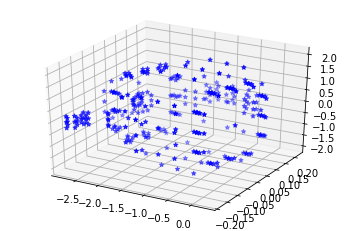

In [15]:
## Plot the reconstructed mode

# In the base code above we copied the x, y and z component of the 3D points
# in teapot 3D model that we loaded from teapot.mat in variables a, b, and c respectively
# Assuming the x, y and z component of the reconstructed 3D points are 
# in variables a1, b1 and c1 respectively, the reconstructed model can be plotted as:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a1,b1,c1, c='b', marker='*')

In [16]:
## Evaluate your reconstruction
# In the base code above we copied the x, y and z component of the 3D points
# in teapot 3D model that we loaded from teapot.mat in variables a, b, and c respectively
# Assuming the x, y and z component of the 3D points that you have reconstructed are 
# in variables a1, b1 and c1 respectively, the error in reconstruction can be calcualted as:

err = 0.0
j = 0
for i in range(len(a1)):
  err = err + math.sqrt( ((a1[i]-a[i])*(a1[i]-a[i])) + ((b1[i]-b[i])*(b1[i]-b[i])) + ((c1[i]-c[i])*(c1[i]-c[i])) )
  j=j+1
  
print ("Mean Euclidean Error : ",(err/j))

Mean Euclidean Error :  3.3483136039088843
